# MuchLearningSuchWow - LSTM - Crossvalidation

This notebook contains the code we used to run crossvalidation to find the best parameters for our network. The training code is based loosely on [this kernel](https://www.kaggle.com/bountyhunters/baseline-lstm-with-keras-0-7). The WRMSSE callback uses the same WRMSSE evaluator as the one used in `LSTM_Evaluation.ipynb`, which is based on [this discussion](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834). The Time Series Split used in this kernel was obtained from [this discussion](https://www.kaggle.com/mpearmain/extended-timeseriessplitter) from another Kaggle competition.

### Imports & Data Paths

In [1]:
import numpy as np
import pandas as pd
import pickle
import gc

from WRMSSEEvaluator import WRMSSEEvaluator
from TimeSeriesSplit import TimeSeriesSplit

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, Input, Embedding, Concatenate
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, Callback
from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

import keras.backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
inputPath = "input/m5-forecasting-accuracy/"
outputPath = "output/"
modelPath = "models/"

### Constants

In [3]:
timesteps = 14 # Number of previous days that will be used to predict the next day
startDay = 1000 # Number of days at start of data that will be ignored during training
testSize = 28 # Number of days that will be used as the test set for every fold
useTestWhenFittingScaler = True # Whether or not to use the test fold when fitting the scaler (fixes meaningless average rmse)

# Model settings
add_1dConv = False
node_setup = (50, 400, 400) # Baseline: (50, 400, 400), new setup: (150, 300, 400)
learning_rate = 0.0001

# Rolling means
add_rollingMeans = False

# Crossvalidation loop settings
nr_folds = 5
nr_epochs_per_fold = 3
batch_size = 32

### Loading Data

In [4]:
with open(outputPath + "/preprocessed_train_valid_data.pkl", "rb") as f:
    df_train_valid = pickle.load(f)
with open(outputPath + "/item_data.pkl", "rb") as f:
    item_data = pickle.load(f)

In [5]:
print(item_data.shape)

(0, 30491)


In [6]:
df_train = df_train_valid[:-28] # Remove Kaggle validation data
del df_train_valid
print(df_train.shape)

(913, 30491)


### LSTM Model

In [7]:
def create_LSTM():
    # Note: this function is identical to the one in LSTM_Training.ipynb
    
    model = Sequential()

    # 1D convolution layer
    if(add_1dConv):
        model.add(Conv1D(filters=32, kernel_size=7, strides=1, 
                         padding="causal", activation="relu",
                         input_shape=(item_data.shape[0]+timesteps, # == X_train.shape[1]
                                      df_train.shape[1]))) # == X_train.shape[2]  

    # LSTM layers
    layer_1_units, layer_2_units, layer_3_units = node_setup
    
    if(add_1dConv):
        model.add(LSTM(units = layer_1_units, return_sequences = True))
    else:
        model.add(LSTM(units = layer_1_units, 
                       return_sequences = True, 
                       input_shape=(item_data.shape[0]+timesteps, df_train.shape[1])))
    model.add(Dropout(0.3))

    model.add(LSTM(units = layer_2_units, return_sequences = True))
    model.add(Dropout(0.3))

    model.add(LSTM(units = layer_3_units))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(units = 30490))
    
    return model

In [8]:
model = create_LSTM()
plot_model(model, modelPath + "/model.png")
print(model.summary())
del model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 14, 50)            6108400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 400)           721600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30490)            

### WRMSSE Evaluation Callback

In [9]:
class WRMSSECallback(Callback):
    
    def __init__( self, df_train_orginal, df_valid_original, df_calendar, df_prices, timesteps, 
                  input_data, item_data, scaler, nr_days_to_predict, additional_features, val_start_day):
        # Create evaluator and set all values necessary for testing & evaluation
        self.evaluator = WRMSSEEvaluator(df_train_orginal, df_valid_original, df_calendar, df_prices)
        self.timesteps = timesteps
        self.input_data = input_data
        self.item_data = item_data
        self.scaler = scaler
        self.nr_days_to_predict = nr_days_to_predict
        self.additional_features = additional_features
        self.val_start_day = val_start_day
        
    def compute_rolling_means(self, test_data, predictions):
        # Note: this function is identical to the one in LSTM_Testing.ipynb
        
        # Compute the next row of rolling means (this implementation works because input_data contains more than 7 days)
        test_data = np.squeeze(test_data)
        df_test_pred = pd.DataFrame(np.concatenate([test_data[:,:30490], predictions], axis = 0))
        rolling_mean = pd.DataFrame(df_test_pred.rolling(7).mean())
        rolling_mean = rolling_mean.fillna(0)

        return rolling_mean[-1:]
        
    def test_model( self, model ):
        # Note: this function is identical to the one in LSTM_Testing.ipynb
        
        # Scale and convert input data so that it can be fed into the model
        inputs = self.scaler.transform(self.input_data)
        X_test = np.array([inputs])
    
        # Predict sales for the next nr_days_to_predict days
        predictions = []
        for j in range(0, self.nr_days_to_predict):
            feature_shape = 30490 + additional_features.shape[1]
            if(add_rollingMeans):
                feature_shape += 30490 # If rolling means are present, feature_shape is 30490 + # additional features + 30490
            model_input = np.append(np.expand_dims(item_data, 0), 
                                    X_test[:,-self.timesteps:,:].reshape(1, self.timesteps, feature_shape), axis = 1)
            predicted_sales = model.predict(model_input)
            to_stack = [np.array(predicted_sales), self.additional_features.iloc[[j]]]
            if(add_rollingMeans): # If rolling means are required, compute them and add them to model_output
                rolling_means = self.compute_rolling_means(X_test, predicted_sales)
                to_stack.append(rolling_means)
            model_output = np.column_stack(tuple(to_stack))
            model_output_expanded = np.expand_dims(model_output, 0)
            X_test = np.append(X_test, model_output_expanded, axis = 1)
            predicted_sales = self.scaler.inverse_transform(model_output)[:,0:30490]
            predictions.append(predicted_sales)
    
        return predictions
    
    def evaluate( self, predictions ):
        # Reshape predictions in order to feed them to the evaluator
        predictions = pd.DataFrame(data=np.array(predictions).reshape(self.nr_days_to_predict,30490))
        predictions = predictions.T
        predictions.columns = [f"d_{i}" for i in range(self.val_start_day,self.val_start_day + self.nr_days_to_predict)]
        
        # Compute and return WRMSSE
        groups, scores = self.evaluator.score(predictions)
        wrmsse_score = np.mean(scores)
        
        return wrmsse_score
    
    def on_epoch_end( self, epoch, logs=None ):
        logs = logs or {}
        # Predict using the current state of the model, compute WRMSSE, add the result to the log and print it
        predictions = self.test_model(self.model)
        wrmsse_score = self.evaluate(predictions)
        logs['val_wrmsse'] = wrmsse_score
        print("Validation WRMSSE after epoch "+str(epoch+1)+": "+str(wrmsse_score))

In [10]:
# WRMSSE evaluator requires original, non-preprocessed data
df_sales = pd.read_csv(inputPath + "/sales_train_evaluation.csv")
df_calendar = pd.read_csv(inputPath + "/calendar.csv")
df_prices = pd.read_csv(inputPath + "/sell_prices.csv")

### Time Series Cross Validation

In [11]:
# Define the loss function (RMSE)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [12]:
# Create time series splitter
tss = TimeSeriesSplit(nr_folds, test_size=testSize)

In [13]:
# Cross Validation Loop
histories = []
for fold, (train_index, test_index) in enumerate(tss.split(range(0,df_train.shape[0]-timesteps))):
    # Change fold from index to number and print the current fold
    fold += 1
    print("Fold "+str(fold)+"/"+str(nr_folds))

    # Create scaled data for the current fold (test data is used in fit as well, to make rmse more meaningful)
    print("Scaling data...")
    scaler = MinMaxScaler(feature_range = (0, 1))
    if(useTestWhenFittingScaler):
        df_split_scaled = scaler.fit_transform(df_train[:timesteps+len(train_index)+len(test_index)])
    else:
        df_train_split_scaled = scaler.fit_transform(df_train[:timesteps+len(train_index)])
        df_test_split_scaled = scaler.transform(df_train[timesteps+len(train_index):timesteps+len(train_index)+len(test_index)])
        df_split_scaled = np.append(df_train_split_scaled, df_test_split_scaled, axis = 0)
    
    # Create training and testing sets for the current split
    print("Creating training and testing splits...")
    X_train_split, y_train_split, X_test_split, y_test_split = [],[],[],[]
    for i in range(timesteps, timesteps+len(train_index)):
        X_train_split.append(np.append(item_data, df_split_scaled[i-timesteps:i], axis = 0))
        y_train_split.append(df_split_scaled[i][0:30490]) # Only use first 30490 columns (sales) as labels
    for i in range(timesteps+len(train_index), timesteps+len(train_index)+len(test_index)):
        X_test_split.append(np.append(item_data, df_split_scaled[i-timesteps:i], axis = 0))
        y_test_split.append(df_split_scaled[i][0:30490]) # Only use first 30490 columns (sales) as labels
    del df_split_scaled
    
    # Convert training and testing sets to numpy arrays so that they can be fed to the model
    X_train_split = np.array(X_train_split)
    y_train_split = np.array(y_train_split)
    X_test_split = np.array(X_test_split)
    y_test_split = np.array(y_test_split)
    
    # Create a new model
    model = create_LSTM()
    
    # Compile the model
    model.compile(optimizer = Adam(learning_rate=learning_rate), loss = root_mean_squared_error)
    
    # Create WRMSSE evaluation callback
    val_start_day = startDay+len(train_index)+timesteps+1
    df_train_original = df_sales
    df_valid_original = df_sales.iloc[:, val_start_day+5:val_start_day+5+testSize]
    input_data = df_train[len(train_index):len(train_index)+timesteps]
    additional_features = df_train[len(train_index)+timesteps:len(train_index)+timesteps+testSize].iloc[:, 30490:]
    if(add_rollingMeans):
        additional_features = additional_features.iloc[:, :-30490]
    print("Creating WRMSSE callback...")
    wrmsse_valid = WRMSSECallback( df_train_original, df_valid_original, df_calendar, df_prices, timesteps, 
                                   input_data, item_data, scaler, testSize, additional_features, val_start_day)
    
    # Create callbacks that save the models with the lowest validation loss and WRMSSE score
    mcp_save_loss = ModelCheckpoint(modelPath + "/lstm_model_best_loss_"+str(fold), 
                                    save_best_only=True, monitor='val_loss', mode='min')
    mcp_save_wrmsse = ModelCheckpoint(modelPath + "/lstm_model_best_wrmsse_"+str(fold), 
                                      save_best_only=True, monitor='val_wrmsse', mode='min')
        
    # Fit the model
    hist = model.fit(X_train_split, y_train_split, 
                     epochs = nr_epochs_per_fold, 
                     validation_data = (X_test_split, y_test_split), 
                     batch_size = batch_size, 
                     verbose = 1,
                     callbacks = [wrmsse_valid, mcp_save_loss, mcp_save_wrmsse])
    
    # Save the final model
    model.save(modelPath + "/lstm_model_final_"+str(fold))
    
    # Store history and perform garbage collection
    histories.append(hist)
    del model
    del X_train_split
    del y_train_split
    del X_test_split
    del y_test_split
    del val_start_day
    del df_train_original
    del df_valid_original
    del input_data
    del additional_features
    del wrmsse_valid
    del mcp_save_loss
    del mcp_save_wrmsse
    del scaler
    gc.collect()
    print("\n")

Fold 1/5
Scaling data...
Creating training and testing splits...
Creating WRMSSE callback...



Train on 275 samples, validate on 28 samples
Epoch 1/3
275/275 [==============================] - 7s 24ms/step - loss: 0.2044 - val_loss: 0.2140
Validation WRMSSE after epoch 1: 4.41479511942408
Epoch 2/3
275/275 [==============================] - 6s 20ms/step - loss: 0.1951 - val_loss: 0.1925
Validation WRMSSE after epoch 2: 2.612272376145938
Epoch 3/3
275/275 [==============================] - 5s 20ms/step - loss: 0.1749 - val_loss: 0.1807
Validation WRMSSE after epoch 3: 0.965651479050834


Fold 2/5
Scaling data...
Creating training and testing splits...
Creating WRMSSE callback...



Train on 424 samples, validate on 28 samples
Epoch 1/3
424/424 [==============================] - 9s 22ms/step - loss: 0.1921 - val_loss: 0.1898
Validation WRMSSE after epoch 1: 3.8195253889153276
Epoch 2/3
424/424 [==============================] - 8s 20ms/step - loss: 0.1713 - val_loss: 0.1673
Validation WRMSSE after epoch 2: 1.0918209186706038
Epoch 3/3
424/424 [==============================] - 8s 20ms/step - loss: 0.1595 - val_loss: 0.1667
Validation WRMSSE after epoch 3: 1.066724981570329


Fold 3/5
Scaling data...
Creating training and testing splits...
Creating WRMSSE callback...



Train on 573 samples, validate on 28 samples
Epoch 1/3
573/573 [==============================] - 12s 20ms/step - loss: 0.1823 - val_loss: 0.1810
Validation WRMSSE after epoch 1: 3.0400048431264075
Epoch 2/3
573/573 [==============================] - 11s 19ms/step - loss: 0.1578 - val_loss: 0.1675
Validation WRMSSE after epoch 2: 1.3765850038589156
Epoch 3/3
573/573 [==============================] - 11s 18ms/step - loss: 0.1527 - val_loss: 0.1663
Validation WRMSSE after epoch 3: 1.1586141772118994


Fold 4/5
Scaling data...
Creating training and testing splits...
Creating WRMSSE callback...



Train on 722 samples, validate on 28 samples
Epoch 1/3
722/722 [==============================] - 14s 20ms/step - loss: 0.1744 - val_loss: 0.1633
Validation WRMSSE after epoch 1: 1.1872720022233638
Epoch 2/3
722/722 [==============================] - 13s 19ms/step - loss: 0.1509 - val_loss: 0.1594
Validation WRMSSE after epoch 2: 1.155972153903481
Epoch 3/3
722/722 [==============================] - 13s 18ms/step - loss: 0.1482 - val_loss: 0.1588
Validation WRMSSE after epoch 3: 1.1486652402118198


Fold 5/5
Scaling data...
Creating training and testing splits...
Creating WRMSSE callback...



Train on 871 samples, validate on 28 samples
Epoch 1/3
871/871 [==============================] - 17s 20ms/step - loss: 0.1669 - val_loss: 0.1591
Validation WRMSSE after epoch 1: 1.2540353961419592
Epoch 2/3
871/871 [==============================] - 16s 18ms/step - loss: 0.1459 - val_loss: 0.1594
Validation WRMSSE after epoch 2: 1.4207492234793335
Epoch 3/3
871/871 [==============================] - 16s 19ms/step - loss: 0.1444 - val_loss: 0.1587
Validation WRMSSE after epoch 3: 1.3615619268985641




### Processing Results

In [14]:
train_losses = []
val_losses = []
val_wrmsses = []
for fold in histories:
    train_losses.append(fold.history['loss'])
    val_losses.append(fold.history['val_loss'])
    val_wrmsses.append(fold.history['val_wrmsse'])

In [15]:
print("Lowest average training loss: {:f} after epoch {:d}"
      .format(np.min(np.mean(train_losses, axis = 0)),
              np.argmin(np.mean(train_losses, axis = 0))+1))
print("Lowest average validation loss: {:f} after epoch {:d}"
      .format(np.min(np.mean(val_losses, axis = 0)),
              np.argmin(np.mean(val_losses, axis = 0))+1))
print("Lowest average validation WRMSSE: {:f} after epoch {:d}"
      .format(np.min(np.mean(val_wrmsses, axis = 0)),
              np.argmin(np.mean(val_wrmsses, axis = 0))+1))

Lowest average training loss: 0.155957 after epoch 3
Lowest average validation loss: 0.166231 after epoch 3
Lowest average validation WRMSSE: 1.140244 after epoch 3


### Plotting Losses

In [16]:
def plot_loss(train_losses, val_losses, nr_epochs, title):
    fig, ax = plt.subplots()
    ax.grid()
    
    ax.plot(np.arange(1, nr_epochs+1), np.mean(train_losses, axis = 0), label='train_loss', color = 'blue')
    ax.plot(np.arange(1, nr_epochs+1), np.mean(val_losses, axis = 0), label='val_loss', color = 'red')
    
    max_train_loss = np.amax(train_losses, axis = 0)
    min_train_loss = np.amin(train_losses, axis = 0)
    ax.fill_between(np.arange(1, nr_epochs+1), max_train_loss, min_train_loss, alpha = 0.2, color = 'blue')
    
    max_val_loss = np.max(val_losses, axis = 0)
    min_val_loss = np.min(val_losses, axis = 0)
    ax.fill_between(np.arange(1, nr_epochs+1), max_val_loss, min_val_loss, alpha = 0.2, color = 'red')
    
    ax.title.set_text(title)
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    plt.show()
    
def plot_wrmsse(val_wrmsses, nr_epochs, title):
    fix, ax = plt.subplots()
    ax.grid()
    
    ax.plot(np.arange(1, nr_epochs+1), np.mean(val_wrmsses, axis = 0), label='val_wrmsse', color = 'green')
    
    max_val_wrmsse = np.amax(val_wrmsses, axis = 0)
    min_val_wrmsse = np.amin(val_wrmsses, axis = 0)
    ax.fill_between(np.arange(1, nr_epochs+1), max_val_wrmsse, min_val_wrmsse, alpha = 0.2, color = 'green')
    
    ax.title.set_text(title)
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('WRMSSE')
    ax.legend(loc='upper right')
    plt.show()

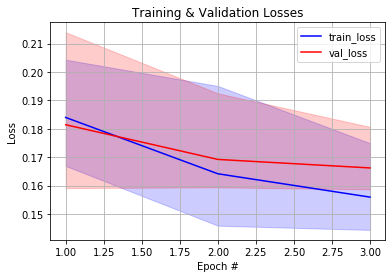

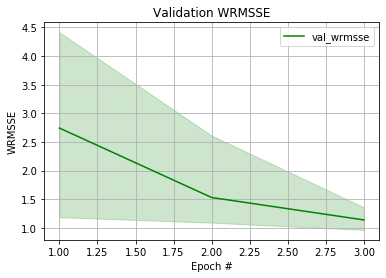

In [17]:
plot_loss(train_losses, val_losses, nr_epochs_per_fold, 'Training & Validation Losses')
plot_wrmsse(val_wrmsses, nr_epochs_per_fold, 'Validation WRMSSE')